In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import regex
import scipy.stats as stats
import scipy.optimize as optimize
import scipy.signal as signal
from scipy import cluster
from Bio import SeqIO
from ECvariables import *
%matplotlib inline

sns.set_style('white')
plt.rcParams['xtick.labelsize']=15
plt.rcParams['ytick.labelsize']=15

In [2]:
#Generate genome reference and operon reference
genome_folder = './data/'
MG1655 = readGenome('./data/NC000913_2.fasta', 1)
MG1655annoteFile = './data/gffEditedNoDup.txt'
annote = readCDSMG1655(MG1655annoteFile, 3)

ecolifasta=loading_fasta_gbk('./data/NC000913_2.fasta','fasta')
ecoligbk=loading_fasta_gbk('./data/NC_000913_2.gbk','genbank')
genome=reading_gbk_new(ecoligbk,['CDS','tRNA','rRNA','ncRNA'])

MGoperons = pd.read_csv('./data/MGoperons_D19-11576-4278G_with_rpkM.csv', sep = ',', index_col = 0)

##Genome representation
#puts a 1 where there is a gene

genome_gene_representation = np.zeros([1,len(ecolifasta.seq)])

for genes in [genome]:
    for i in range (0, len(genes.annotation)):
        if genes.strand[i]== +1:
            
            for j in range(0, genes.length[i]-1):
                genome_gene_representation[0][genes.start[i]+j]=10
        else:
            for j in range(0,genes.length[i]-1):
                genome_gene_representation[0][genes.end[i]+j]=-10
                
##calculating ATcontent
sliding_100=sliding_window(100)

In [3]:
#Load in data
chip = loadChipData()
RNAseq = loadRNAseqData()

/home/msguo/.local/lib/python3.6/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


### Fig. 3B

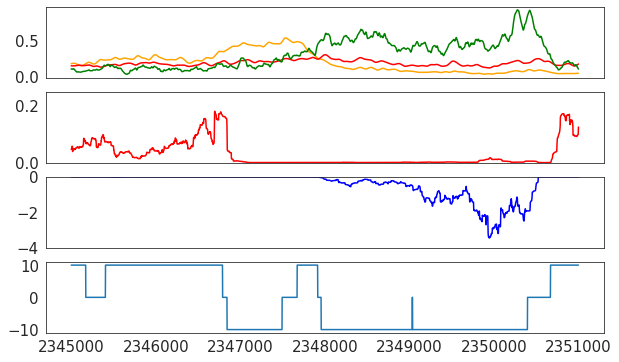

In [4]:
start = 2345000
end = 2351000
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(10,6), sharey=False)
axes[0].plot(np.arange(start, end),chip.high[start:end],'orange')
axes[0].plot(np.arange(start, end),chip.Rif_high[start:end],'red')
axes[0].plot(np.arange(start, end),chip['76_rep2'][start:end],'green')

axes[1].plot(np.arange(start, end),(RNAseq['fwd'][start:end]),'red')
axes[2].plot(np.arange(start, end),-(RNAseq['rev'][start:end]),'blue')

axes[1].set_ylim(0, 0.25)
axes[2].set_ylim(-4, 0)

axes[0].get_xaxis().set_visible(False)
axes[1].get_xaxis().set_visible(False)
axes[2].get_xaxis().set_visible(False)

axes[3].plot(np.arange(start, end), genome_gene_representation[0,start:end])

### Fig 3C

In [5]:
#Exclude rRNA loci
chip_76_mask = maskrRNA(chip['76_rep2'].astype(float))
chip_high_mask = maskrRNA(chip.high.astype(float))

(0.3122418769778775, 0.0)


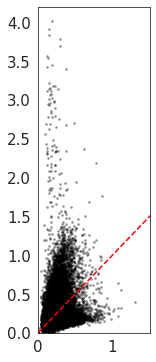

In [6]:
#bin data, 100 bp
rep1 = np.nancumsum(chip_high_mask)
rep2 = np.nancumsum(chip_76_mask)

N = 100
av_rep1 = []
av_rep2 = []
for x in np.arange(0,len(ecolifasta.seq),N):
    try:
        av_rep1.append((rep1[x+N]-rep1[x])/N)
        av_rep2.append((rep2[x+N]-rep2[x])/N)
    except:
        av_rep1.append((rep1[len(ecolifasta.seq)-1]-rep1[x])/N)
        av_rep2.append((rep2[len(ecolifasta.seq)-1]-rep2[x])/N)
        

plt.figure(figsize=(2,6))
plt.scatter(av_rep1,av_rep2, marker = 'o', s = 3, c = 'black', edgecolors = 'face', alpha = 0.3)
plt.plot([0,4.2],[0,4.2],'--',c='red')
plt.ylim([0,4.2])
plt.xlim([0,1.5])
print(stats.pearsonr(av_rep1,av_rep2))

### Fig. 3E

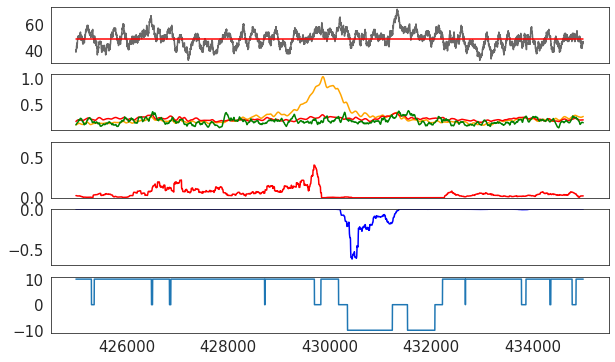

In [7]:
start = 425000
end = 435000
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(10,6), sharey=False)
axes[0].plot(np.arange(start, end),sliding_100[0][start:end],'dimgrey')
axes[0].plot([start, end],[np.mean(sliding_100[0]),np.mean(sliding_100[0])],'red')
axes[1].plot(np.arange(start, end),chip.high[start:end],'orange')
axes[1].plot(np.arange(start, end),chip.Rif_high[start:end],'red')
axes[1].plot(np.arange(start, end),chip['76_rep1'][start:end],'green')

axes[2].plot(np.arange(start, end),(RNAseq['fwd'][start:end]),'red')
axes[3].plot(np.arange(start, end),-(RNAseq['rev'][start:end]),'blue')

axes[2].set_ylim(0, 0.7)
axes[3].set_ylim(-0.7, 0)

axes[0].get_xaxis().set_visible(False)
axes[1].get_xaxis().set_visible(False)
axes[2].get_xaxis().set_visible(False)
axes[3].get_xaxis().set_visible(False)

axes[4].plot(np.arange(start, end), genome_gene_representation[0,start:end])

### Fig. 3F-G

In [8]:
annote = returnAnnote(RNAseq)
high_exp = MGoperons[MGoperons.newRPK >= 17.3]
chip_diff = chip.high-chip.Rif_high

df_regions = pd.concat([high_exp,high_exp.shift(-1)],axis=1,keys=['left','right'],names=['gene'])
df_regions.columns = ['{}_{}'.format(x,y) for x,y in df_regions.columns]
df_regions = df_regions.dropna(subset=['right_start'])
df_regions = df_regions.rename(columns={'left_Unnamed: 0.1':'left_operonName','right_Unnamed: 0.1':'right_operonName'})
df_regions.loc[df_regions['left_strand']==df_regions['right_strand'],'intergenic_type']='same'
df_regions.loc[(df_regions['left_strand']==0) & (df_regions['right_strand']==1),'intergenic_type']='conv'
df_regions.loc[(df_regions['left_strand']==1) & (df_regions['right_strand']==0),'intergenic_type']='div'

df_regions['intergenic_mean_gapR']=df_regions.apply(lambda r:chip.high.loc[r['left_end']:r['right_start']].mean(),axis=1)
df_regions['intergenic_mean_gapR_rif']=df_regions.apply(lambda r:chip_diff.loc[r['left_end']:r['right_start']].mean(),axis=1)
df_regions['intergenic_length']=df_regions.apply(lambda r:r['right_start']-r['left_end'],axis=1)
df_final = df_regions[df_regions.intergenic_length >50] #filter out things that are within 20 bases

annote['intragenic_mean_gapR']=annote.apply(lambda r:chip.high.loc[r['start']:r['end']].mean(),axis=1)
annote['intragenic_mean_gapR_rif']=annote.apply(lambda r:chip_diff.loc[r['start']:r['end']].mean(),axis=1)
annote_final = annote[annote.newRPK >=17.3] #filter out off genes

conv 162 Ttest_indResult(statistic=0.0, pvalue=1.0)
div 171 Ttest_indResult(statistic=6.609367034222488, pvalue=1.5452378304771288e-10)
same 448 Ttest_indResult(statistic=4.550860896010719, pvalue=6.453614731207668e-06)
intra 2497 Ttest_indResult(statistic=12.221786345944087, pvalue=1.8492727727657596e-33)


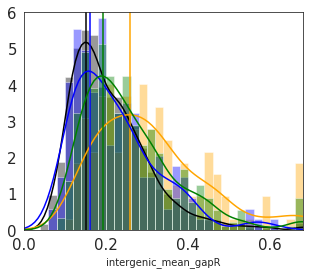

In [9]:
#Fig 3F
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(5,4))
bins = np.arange(0,0.7,0.02)
sns.distplot(annote_final['intragenic_mean_gapR'].clip(bins[0],bins[-1]),bins=bins,color='black')
kde = stats.gaussian_kde(annote_final['intragenic_mean_gapR'])
xs = np.linspace(-0.3, 0.5, 100)
y1 = kde(xs)
plt.plot([xs[np.argmax(y1)],xs[np.argmax(y1)]],[0,20],'-',color='black')

colors={'same':'green','div':'blue','conv':'orange'}
for i,g in df_final.groupby('intergenic_type'):
    sns.distplot(g['intergenic_mean_gapR'].clip(bins[0],bins[-1]),bins=bins,color=colors[i],label=i)
    print(i,len(g),stats.ttest_ind(df_final[df_final.intergenic_type == 'conv'].intergenic_mean_gapR,g.intergenic_mean_gapR))
    kde = stats.gaussian_kde(g['intergenic_mean_gapR'])
    xs = np.linspace(-0.3, 0.5, 100)
    y1 = kde(xs)
    plt.plot([xs[np.argmax(y1)],xs[np.argmax(y1)]],[0,20],'-',color=colors[i])

plt.xlim([bins[0],bins[-1]])
plt.ylim([0,6])

print('intra',len(annote_final),stats.ttest_ind(df_final[df_final.intergenic_type == 'conv'].intergenic_mean_gapR,annote_final.intragenic_mean_gapR))

conv 162 Ttest_indResult(statistic=0.0, pvalue=1.0)
div 171 Ttest_indResult(statistic=12.253122069571022, pvalue=1.0174478014042956e-28)
same 448 Ttest_indResult(statistic=7.6817360022950565, pvalue=6.309659047057819e-14)
intra 2497 Ttest_indResult(statistic=14.019264248088787, pvalue=3.936578098599822e-43)


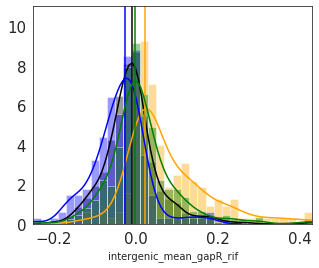

In [10]:
#Fig 3G
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(5,4))
bins = np.arange(-0.25,0.45,0.02)
sns.distplot(annote_final['intragenic_mean_gapR_rif'].clip(bins[0],bins[-1]),bins=bins,color='black')
kde = stats.gaussian_kde(annote_final['intragenic_mean_gapR_rif'])
xs = np.linspace(-0.3, 0.5, 100)
y1 = kde(xs)
plt.plot([xs[np.argmax(y1)],xs[np.argmax(y1)]],[0,20],'-',color='black')

colors={'same':'green','div':'blue','conv':'orange'}
for i,g in df_final.groupby('intergenic_type'):
    sns.distplot(g['intergenic_mean_gapR_rif'].clip(bins[0],bins[-1]),bins=bins,color=colors[i],label=i)
    print(i,len(g),stats.ttest_ind(df_final[df_final.intergenic_type == 'conv'].intergenic_mean_gapR_rif,g.intergenic_mean_gapR_rif))
    kde = stats.gaussian_kde(g['intergenic_mean_gapR_rif'])
    xs = np.linspace(-0.3, 0.5, 100)
    y1 = kde(xs)
    plt.plot([xs[np.argmax(y1)],xs[np.argmax(y1)]],[0,20],'-',color=colors[i])

plt.xlim([bins[0],bins[-1]])
plt.ylim([0,11])

print('intra',len(annote_final),stats.ttest_ind(df_final[df_final.intergenic_type == 'conv'].intergenic_mean_gapR_rif,annote_final.intragenic_mean_gapR_rif))

### Fig. 3H

In [11]:
out_high = enrichedRegions(chip.high-chip.Rif_high,.11849042) #this is the 5% of positions with greatest GapR enrichment
print(len(out_high))

chip_diff = chip.high-chip.Rif_high

#expand GapR ChIP peaks
out = []
regions = out_high
m = np.mean(chip_diff)
s = np.std(chip_diff)
for i in range(len(regions)):
    z = regions[i]
    c = chip_diff.loc[z[0]-15000:z[1]+15000]
    c_diff = c[c>(m+1/3*s)]#c[c>0.07265350753477769]=1 std above the mean, I'm choosing 1/3 of a std
    j = z[1]
    while j < z[1]+15000:
        try:
            c_diff[j+1]
            j +=1
        except:
            end = j
            j = z[1]+15000
    j = z[0]
    while j > z[0]-15000:
        try:
            c_diff[j-1]
            j -=1
        except:
            start = j
            j = z[0]-15000
    if start > end:
        print('problem!')
    out.append(tuple([start,end]))
    
regions = sorted(list(set(out)))
out = []

i = 1
z = regions[0]
start = z[0]
end = z[1]
while i < len(regions):
    if regions[i][0] <= regions[i-1][1] + 150: #this is the merge number, why did I pick 1000?
        end = regions[i][1]
#        print 'yes', regions[i][0], regions[i][1]
        i += 1
    else:
#        print 'no', i, regions[i][0], regions[i][1]
        out.append([start,end])
        i += 1
        z = regions[i-1]
        start = z[0]
        end = z[1]
out.append([start,end])
print(len(out))
GapR_peaks = out

915
223


In [12]:
outu_high = unenrichedRegions(chip.high-chip.Rif_high,-0.0885)#-0.102259) this 5%

#expand GapR ChIP peaks
out = []
regions = outu_high
m = np.mean(chip_diff)
s = np.std(chip_diff)
for i in range(len(regions)):
    z = regions[i]
    c = chip_diff.loc[z[0]-15000:z[1]+15000]
    c_diff = c[c<(m-1/3*s)]#I'm choosing 1/3 of a std
    j = z[1]
    start = z[0]
    end = z[1]
    while j < z[1]+15000:
        try:
            c_diff[j+1]
            j +=1
        except:
            end = j
            j = z[1]+15000
    j = z[0]
    while j > z[0]-15000:
        try:
            c_diff[j-1]
            j -=1
        except:
            start = j
            j = z[0]-15000
    if start > end:
        print('problem!',i,start,end)
    out.append(tuple([start,end]))
    
regions = sorted(list(set(out)))
out = []

i = 1
z = regions[0]
start = z[0]
end = z[1]
while i < len(regions):
    if regions[i][0] <= regions[i-1][1] + 150: #merge peaks within 150 bp
        end = regions[i][1]
        i += 1
    else:
        out.append([start,end])
        i += 1
        z = regions[i-1]
        start = z[0]
        end = z[1]
out.append([start,end])
outu_compress = out

In [13]:
#outu_compress vs divergent vs same direction for unenriched
direction_u = []
for i in outu_compress[2:]:
    txn_avg = np.mean(RNAseq.fwd[i[0]-5000:i[1]+5000].values+RNAseq.rev[i[0]-5000:i[1]+5000].values)
    mid = int(round(np.mean(i),0))
    if txn_avg < 0.01:
        direction_u.append('no transcription')
    if txn_avg >= 0.01:
        left_f = np.mean(RNAseq.fwd[i[0]-2000:mid].values)
        left_r = np.mean(RNAseq.rev[i[0]-2000:mid].values)        
        right_f = np.mean(RNAseq.fwd[mid:i[1]+2000].values)
        right_r = np.mean(RNAseq.rev[mid:i[1]+2000].values)        
        if (left_f < 0.01) and (left_r < 0.01):
            left_f = np.mean(RNAseq.fwd[i[0]-5000:mid].values)
            left_r = np.mean(RNAseq.rev[i[0]-5000:mid].values)        
        if (right_f < 0.01) and (right_r < 0.01):
            right_f = np.mean(RNAseq.fwd[mid:i[1]+5000].values)
            right_r = np.mean(RNAseq.rev[mid:i[1]+5000].values)
#        print(round(left_f,4),round(left_r,4),' R',round(right_f,4),round(right_r,4),i)
        if ((left_f < 0.01) and (left_r < 0.01)) or ((right_f < 0.01) and (right_r < 0.01)):
            direction_u.append('same direction')
        elif left_f > left_r:
            if right_r > right_f:
                direction_u.append('convergent')
            else:
                direction_u.append('same direction')
        elif left_f <= left_r:
            if right_r > right_f:
                direction_u.append('same direction')
            else:
                direction_u.append('divergent')


In [14]:
#intergenic regions
intergenic = []
intergenic.append([0,int(annote.start[0])])
for i in range(1,len(annote)-1):
    intergenic.append([int(annote.end[i]),int(annote.start[i+1])])
intergenic.append([int(annote.end[i+1]),len(ecolifasta.seq)])

#convergent vs divergent vs same direction for unenriched
direction_int = []
for i in intergenic[2:-1]:
    txn_avg = np.mean(RNAseq.fwd[i[0]-5000:i[1]+5000].values+RNAseq.rev[i[0]-5000:i[1]+5000].values)
    mid = int(round(np.mean(i),0))
    if txn_avg < 0.01:
        direction_int.append('no transcription')
    if txn_avg >= 0.01:
        left_f = np.mean(RNAseq.fwd[i[0]-2000:mid].values)
        left_r = np.mean(RNAseq.rev[i[0]-2000:mid].values)        
        right_f = np.mean(RNAseq.fwd[mid:i[1]+2000].values)
        right_r = np.mean(RNAseq.rev[mid:i[1]+2000].values)        
        if (left_f < 0.01) and (left_r < 0.01):
            left_f = np.mean(RNAseq.fwd[i[0]-5000:mid].values)
            left_r = np.mean(RNAseq.rev[i[0]-5000:mid].values)        
        if (right_f < 0.01) and (right_r < 0.01):
            right_f = np.mean(RNAseq.fwd[mid:i[1]+5000].values)
            right_r = np.mean(RNAseq.rev[mid:i[1]+5000].values)
#        print(round(left_f,4),round(left_r,4),' R',round(right_f,4),round(right_r,4),i)
        if ((left_f < 0.01) and (left_r < 0.01)) or ((right_f < 0.01) and (right_r < 0.01)):
            direction_int.append('same direction')
        elif left_f > left_r:
            if right_r > right_f:
                direction_int.append('convergent')
            else:
                direction_int.append('same direction')
        elif left_f <= left_r:
            if right_r > right_f:
                direction_int.append('same direction')
            else:
                direction_int.append('divergent')


In [15]:
#convergent vs divergent vs same direction
direction = []
for i in GapR_peaks:
    txn_avg = np.mean(RNAseq.fwd[i[0]-5000:i[1]+5000].values+RNAseq.rev[i[0]-5000:i[1]+5000].values)
    mid = int(round(np.mean(i),0))
    if txn_avg < 0.01:
        direction.append('no transcription')
    if txn_avg >= 0.01:
        left_f = np.mean(RNAseq.fwd[i[0]-2000:mid].values)
        left_r = np.mean(RNAseq.rev[i[0]-2000:mid].values)        
        right_f = np.mean(RNAseq.fwd[mid:i[1]+2000].values)
        right_r = np.mean(RNAseq.rev[mid:i[1]+2000].values)        
        if (left_f < 0.01) and (left_r < 0.01):
            left_f = np.mean(RNAseq.fwd[i[0]-5000:mid].values)
            left_r = np.mean(RNAseq.rev[i[0]-5000:mid].values)        
        if (right_f < 0.01) and (right_r < 0.01):
            right_f = np.mean(RNAseq.fwd[mid:i[1]+5000].values)
            right_r = np.mean(RNAseq.rev[mid:i[1]+5000].values)
#        print(round(left_f,4),round(left_r,4),' R',round(right_f,4),round(right_r,4),i)
        if ((left_f < 0.01) and (left_r < 0.01)) or ((right_f < 0.01) and (right_r < 0.01)):
            direction.append('same direction')
        elif left_f > left_r:
            if right_r > right_f:
                direction.append('convergent')
            else:
                direction.append('same direction')
        elif left_f <= left_r:
            if right_r > right_f:
                direction.append('same direction')
            else:
                direction.append('divergent')
    

In [16]:
dir_gapR = pd.DataFrame(direction)
print('gapR',len(dir_gapR[dir_gapR[0]=='convergent']),len(dir_gapR[dir_gapR[0]=='divergent']),len(dir_gapR[dir_gapR[0]=='same direction']),len(dir_gapR[dir_gapR[0]=='no transcription']),len(dir_gapR))
dir_u = pd.DataFrame(direction_u)
print('unenriched',len(dir_u[dir_u[0]=='convergent']),len(dir_u[dir_u[0]=='divergent']),len(dir_u[dir_u[0]=='same direction']),len(dir_u[dir_u[0]=='no transcription']),len(dir_u))
dir_int = pd.DataFrame(direction_int)
print('intergenic',len(dir_int[dir_int[0]=='convergent']),len(dir_int[dir_int[0]=='divergent']),len(dir_int[dir_int[0]=='same direction']),len(dir_int[dir_int[0]=='no transcription']),len(dir_int))


gapR 78 5 124 16 223
unenriched 2 71 143 7 223
intergenic 427 372 2592 871 4262


In [17]:
print(stats.fisher_exact([[78,5],[427,372]]))
print(stats.fisher_exact([[2,71],[427,372]]))
print(stats.fisher_exact([[78,5],[2,71]]))

(13.590632318501171, 8.101169440173563e-15)
(0.024540686743411286, 5.46768706820398e-20)
(553.8, 1.455606490179016e-35)


### Fig. 3-figure supplement 1D

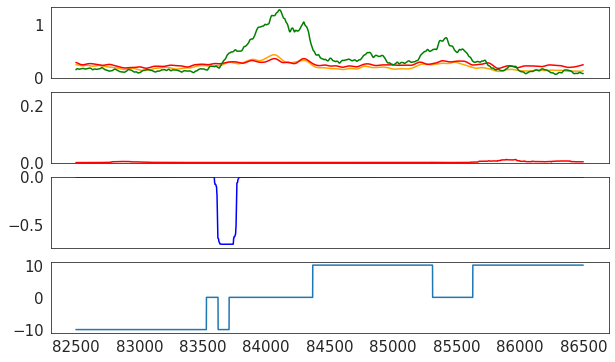

In [18]:
start = 82500
end = 86500
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(10,6), sharey=False)
axes[0].plot(np.arange(start, end),chip.high[start:end],'orange')
axes[0].plot(np.arange(start, end),chip.Rif_high[start:end],'red')
axes[0].plot(np.arange(start, end),chip['76_rep2'][start:end],'green')

axes[1].plot(np.arange(start, end),(RNAseq['fwd'][start:end]),'red')
axes[2].plot(np.arange(start, end),-(RNAseq['rev'][start:end]),'blue')

axes[1].set_ylim(0, 0.25)
axes[2].set_ylim(-.75, 0)

axes[0].get_xaxis().set_visible(False)
axes[1].get_xaxis().set_visible(False)
axes[2].get_xaxis().set_visible(False)

axes[3].plot(np.arange(start, end), genome_gene_representation[0,start:end])

### Fig. 3-figure supplement 1E

In [19]:
high_exp = MGoperons[MGoperons.newRPK >= 17.3]
chip_diff = chip.high-chip.Rif_high

df_regions = pd.concat([high_exp,high_exp.shift(-1)],axis=1,keys=['left','right'],names=['gene'])
df_regions.columns = ['{}_{}'.format(x,y) for x,y in df_regions.columns]
df_regions = df_regions.dropna(subset=['right_start'])
df_regions = df_regions.rename(columns={'left_Unnamed: 0.1':'left_operonName','right_Unnamed: 0.1':'right_operonName'})
df_regions.loc[df_regions['left_strand']==df_regions['right_strand'],'intergenic_type']='same'
df_regions.loc[(df_regions['left_strand']==0) & (df_regions['right_strand']==1),'intergenic_type']='conv'
df_regions.loc[(df_regions['left_strand']==1) & (df_regions['right_strand']==0),'intergenic_type']='div'

df_regions['intergenic_mean_gapR']=df_regions.apply(lambda r:chip['76_rep2'].loc[r['left_end']:r['right_start']].mean(),axis=1)
df_regions['intergenic_length']=df_regions.apply(lambda r:r['right_start']-r['left_end'],axis=1)
df_final = df_regions[df_regions.intergenic_length >50] #filter out things that are within 20 bases

annote['intragenic_mean_gapR']=annote.apply(lambda r:chip['76_rep2'].loc[r['start']:r['end']].mean(),axis=1)
annote_final = annote[annote.newRPK >=17.3] #filter out off genes

conv 162 Ttest_indResult(statistic=0.0, pvalue=1.0)
div 171 Ttest_indResult(statistic=-1.6758362409077678, pvalue=0.09471455578918374)
same 448 Ttest_indResult(statistic=-1.791560244401129, pvalue=0.07370064496748781)
intra 2497 Ttest_indResult(statistic=5.917899676492485, pvalue=3.67972841410239e-09)


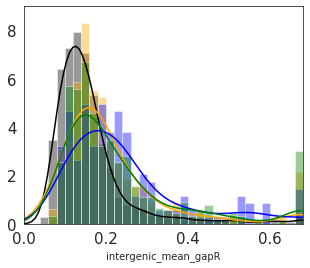

In [20]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(5,4))
bins = np.arange(0,0.7,0.02)
sns.distplot(annote_final['intragenic_mean_gapR'].clip(bins[0],bins[-1]),bins=bins,color='black')
kde = stats.gaussian_kde(annote_final['intragenic_mean_gapR'])
xs = np.linspace(-0.3, 0.5, 100)
y1 = kde(xs)

colors={'same':'green','div':'blue','conv':'orange'}
for i,g in df_final.groupby('intergenic_type'):
    sns.distplot(g['intergenic_mean_gapR'].clip(bins[0],bins[-1]),bins=bins,color=colors[i],label=i)
    print(i,len(g),stats.ttest_ind(df_final[df_final.intergenic_type == 'conv'].intergenic_mean_gapR,g.intergenic_mean_gapR))
    kde = stats.gaussian_kde(g['intergenic_mean_gapR'])
    xs = np.linspace(-0.3, 0.5, 100)
    y1 = kde(xs)

plt.xlim([bins[0],bins[-1]])
plt.ylim([0,9])

print('intra',len(annote_final),stats.ttest_ind(df_final[df_final.intergenic_type == 'conv'].intergenic_mean_gapR,annote_final.intragenic_mean_gapR))

### Fig. 3-figure supplement 1F

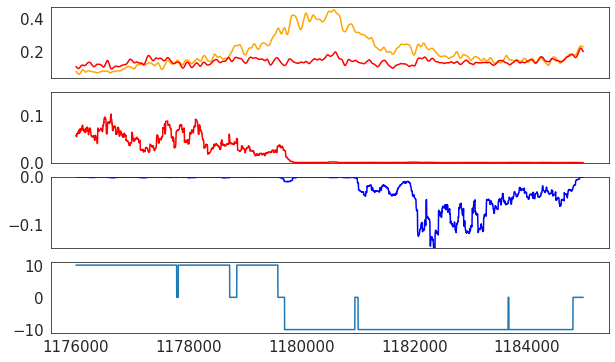

In [21]:
start=1176000
end=1185000
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(10,6), sharey=False)
axes[0].plot(np.arange(start, end),chip.high[start:end],'orange')
axes[0].plot(np.arange(start, end),chip.Rif_high[start:end],'red')

axes[1].plot(np.arange(start, end),(RNAseq['fwd'][start:end]),'red')
axes[1].set_ylim([0,0.15])
axes[2].plot(np.arange(start, end),-(RNAseq['rev'][start:end]),'blue')
axes[2].set_ylim([-0.15,0])

axes[0].get_xaxis().set_visible(False)
axes[1].get_xaxis().set_visible(False)
axes[2].get_xaxis().set_visible(False)

axes[3].plot(np.arange(start, end), genome_gene_representation[0,start:end])

### Fig. 3-figure supplement 1G

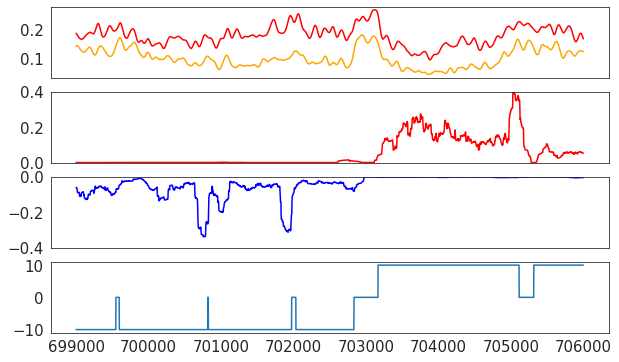

In [22]:
start=699000
end=706000
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(10,6), sharey=False)
axes[0].plot(np.arange(start, end),chip.high[start:end],'orange')
axes[0].plot(np.arange(start, end),chip.Rif_high[start:end],'red')

axes[1].plot(np.arange(start, end),(RNAseq['fwd'][start:end]),'red')
axes[1].set_ylim([0,0.4])
axes[2].plot(np.arange(start, end),-(RNAseq['rev'][start:end]),'blue')
axes[2].set_ylim([-0.4,0])

axes[0].get_xaxis().set_visible(False)
axes[1].get_xaxis().set_visible(False)
axes[2].get_xaxis().set_visible(False)

axes[3].plot(np.arange(start, end), genome_gene_representation[0,start:end])